In [ ]:
import pandas as pd
import pickle

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

In [3]:
def get_data(sample_size):
    df = pd.read_csv(f"res2/{sample_size}-mergedresults.csv",names=['gamma', 'fPos', 'fNeg'], index_col='gamma', skiprows=1)
    with open(f"res2/{sample_size}-votingnets.pickle", 'rb') as f:
        nn = pickle.load( f)

    sizes = {gamma: len(n.keys()) for gamma, [n] in nn.items()}

    dfs = pd.DataFrame.from_dict(sizes, orient='index', columns=['anchors'])
    return df, dfs

def make_double_plot(df, dfs, sample_size):
    fig, axs = plt.subplots(2, 1, figsize=(12,10))
    axs[0].plot(df.fPos,'o-', label='merged: False Pos')
    axs[0].plot(df.fNeg,'o-', label='merged: False Neg')
    axs[0].legend()
    axs[0].set(ylabel='#')

    axs[1].plot(dfs.anchors/sample_size)
    axs[1].set(xlabel=r'$\gamma$', ylabel='Compression')
    for a in axs.flat:
        a.label_outer()


### Experimental setup
1. Data partitionend into 8 (8 is the cpu count on the machine) equally large sets. 
2. For increasing $\gamma$ = [0, 1, 2,...168]
3. Worker Pool of 8 workers, each one creates a $\gamma$-net on its data (in parallel)
4. Networks are mergedn in one shot
5. Merged network is evaluated with test set of 50 apps (false negs, false postives)
6. Networks are serialized (for further testing) 
7. Loop 2


Compression  $=\frac{\text{anchors in network}}{\text{apps in training set}}$

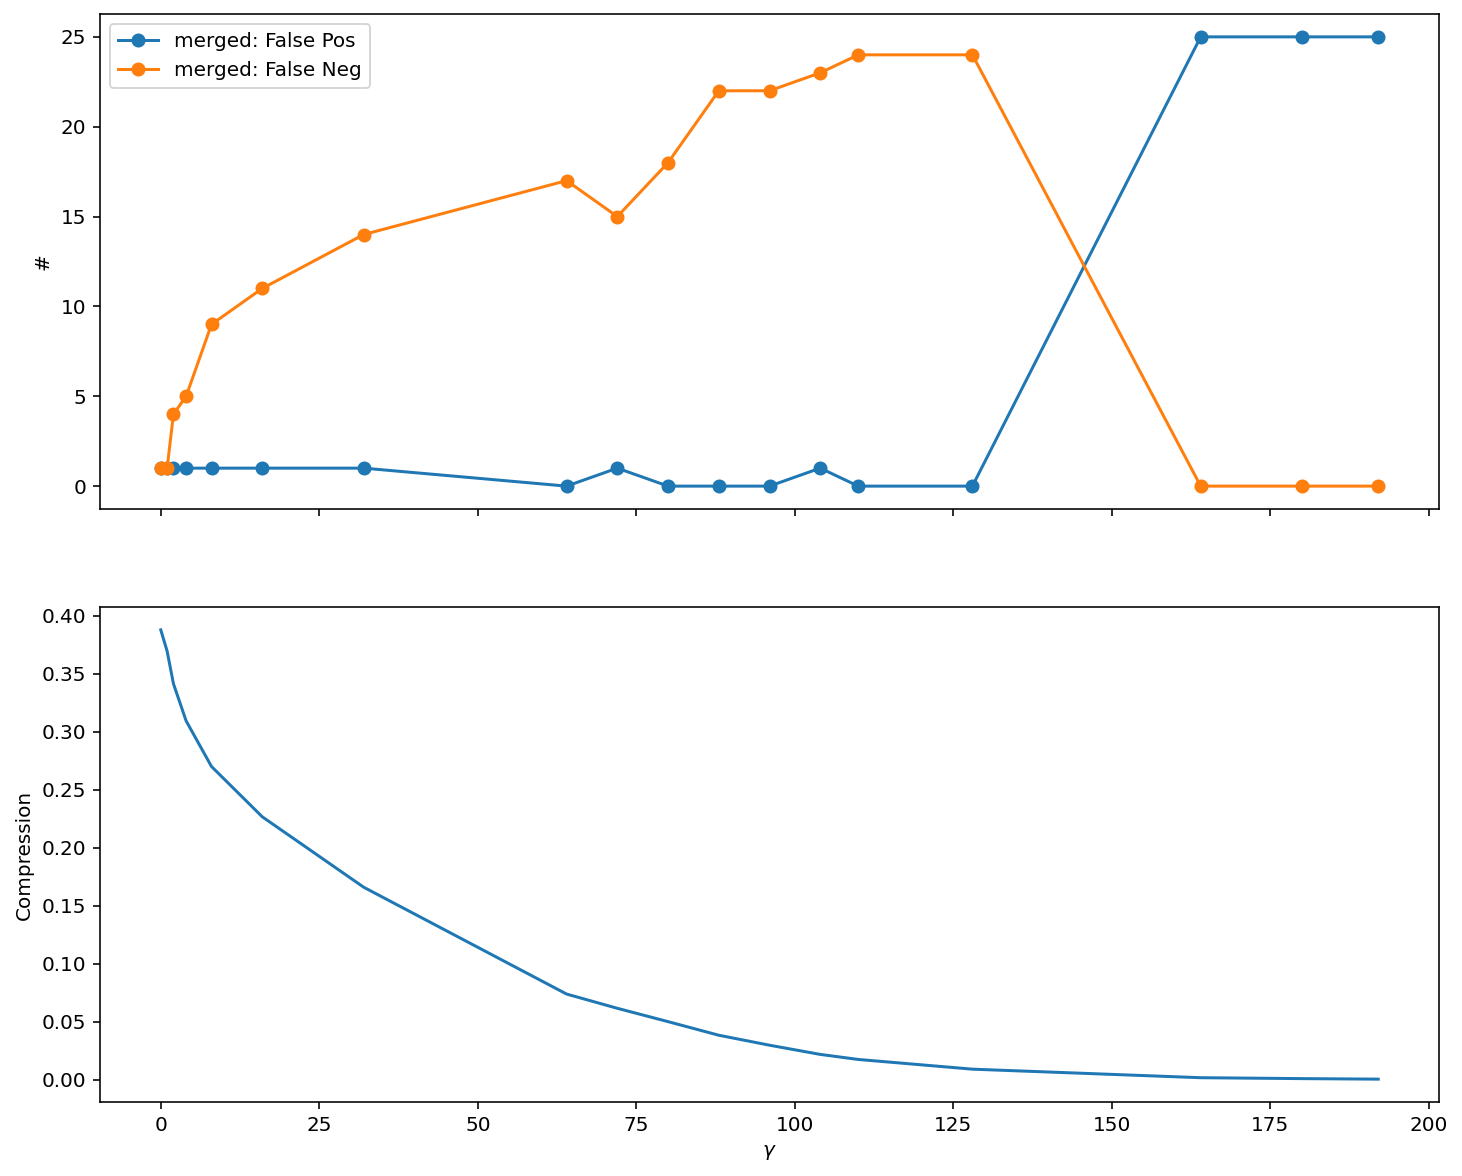

In [94]:
df, dfs = get_data(8950)
make_double_plot(df, dfs, 8950)

### Issues

#### Performance:
1. Network calculation seems not to be the biggest issue (e.g. for $\gamma$ = 1, partition_size ~ 1k apps, elapsed time: 80secs)
1. Networks merging on the other hand is an issue ($\gamma$ = 1 => 3770 secs are needed to merge the 8 partiotions)
1. Hierarchical merging, e.g., pariwise between workers does not really solve the problem: the merges are quicker and partly parallel, but much more have to be conducted: 8 -> 4 -> 2 -> 1. 

#### Partitioning:
So far it was pretty easy to split the data but this is also not so easy in generall case. The file has a structure:
```
 app,func,usage_count
 app2,func2,usage_count
```
Probably for the calcualtion to work, one would need to sort the file, and split it in such a way that all function usages for given app are included in the same partition. It is not easy, and can lead to unbalanced partitions. 


### Appendinx 
Example of smaller experiment with out the ``phase change'' between false positives and negatives

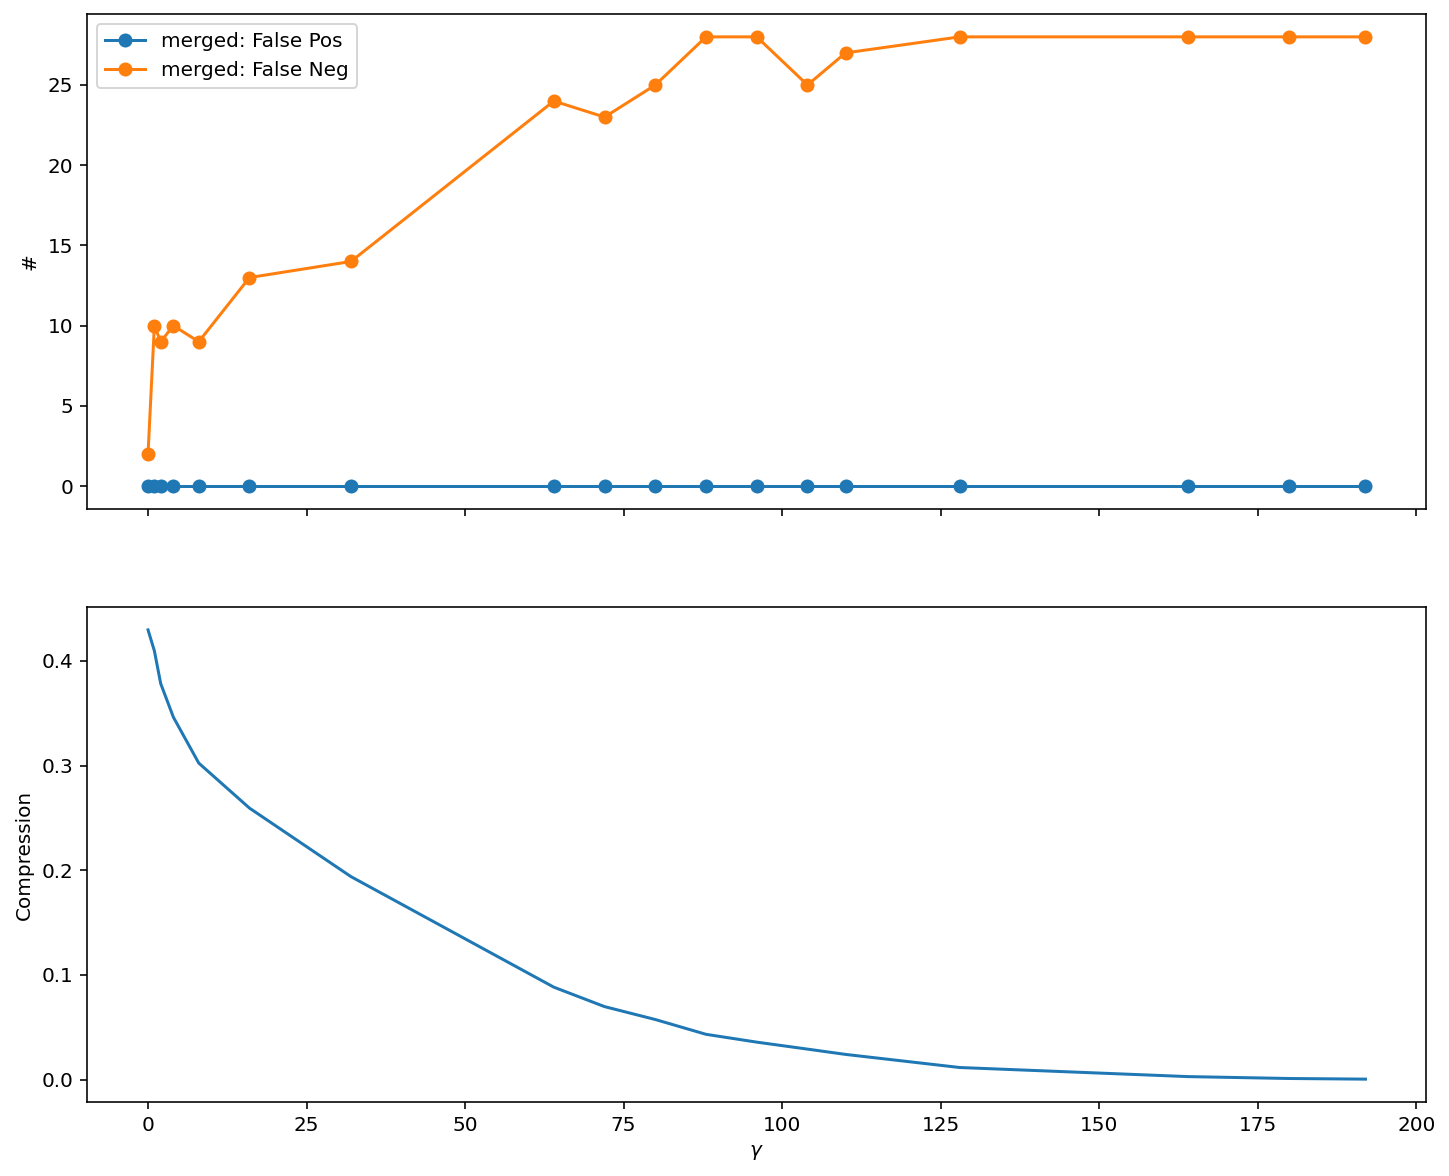

In [93]:
df, dfs = get_data(sample_size=4950)
make_double_plot(df, dfs, 4950)

## Reference network
Not much difference can be seen. In each step after creating merged network a new network on the full data set was crated and evalated with the same test set

In [5]:
def get_new_data(sample_size):
    df = pd.read_csv(f"res2/{sample_size}-mergedresults.csv",
                     names=['gamma', 'mer_fPos', 'mer_fNeg', 'ref_fPos', 'ref_fNeg'], 
                     index_col='gamma', skiprows=1)
    
    with open(f"res2/{sample_size}-votingnets.pickle", 'rb') as f:
        nn = pickle.load( f)

    sizes = {gamma: [len(m.keys()), len(r.keys())] for gamma, [m, r] in nn.items()}

    dfs = pd.DataFrame.from_dict(sizes, orient='index', columns=['mer_anchors', 'ref_anchors'])
    return df, dfs

In [6]:
df, dfs = get_new_data(sample_size=9450)

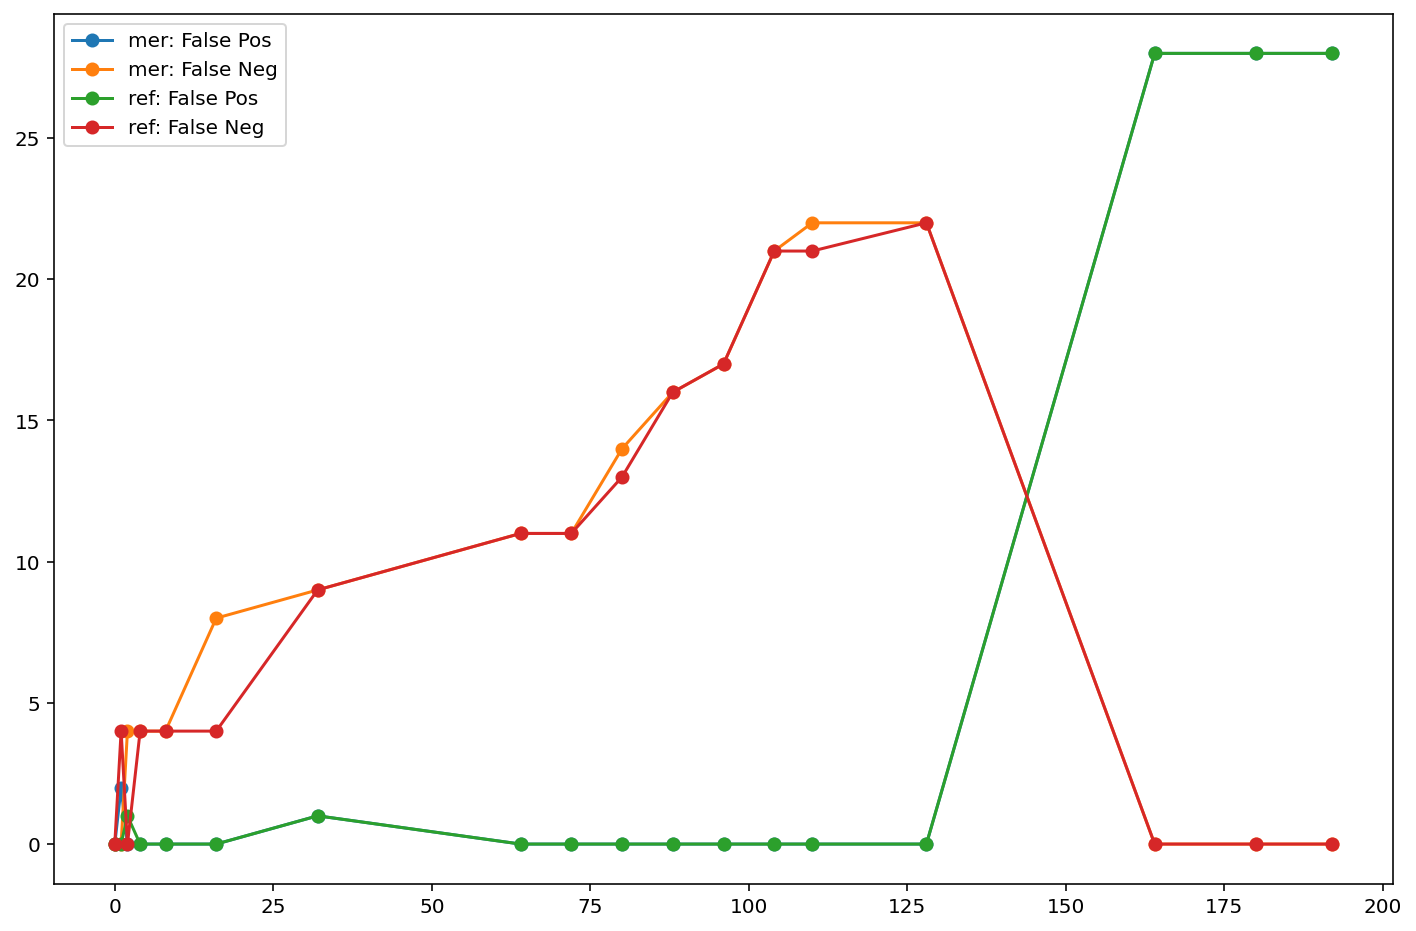

In [8]:
plt.figure(figsize=(12,8))
for prefix in ['mer', 'ref']:
    plt.plot(df[prefix+'_fPos'],'o-', label=prefix+': False Pos')
    plt.plot(df[prefix+'_fNeg'],'o-', label=prefix+': False Neg')
    
plt.legend();

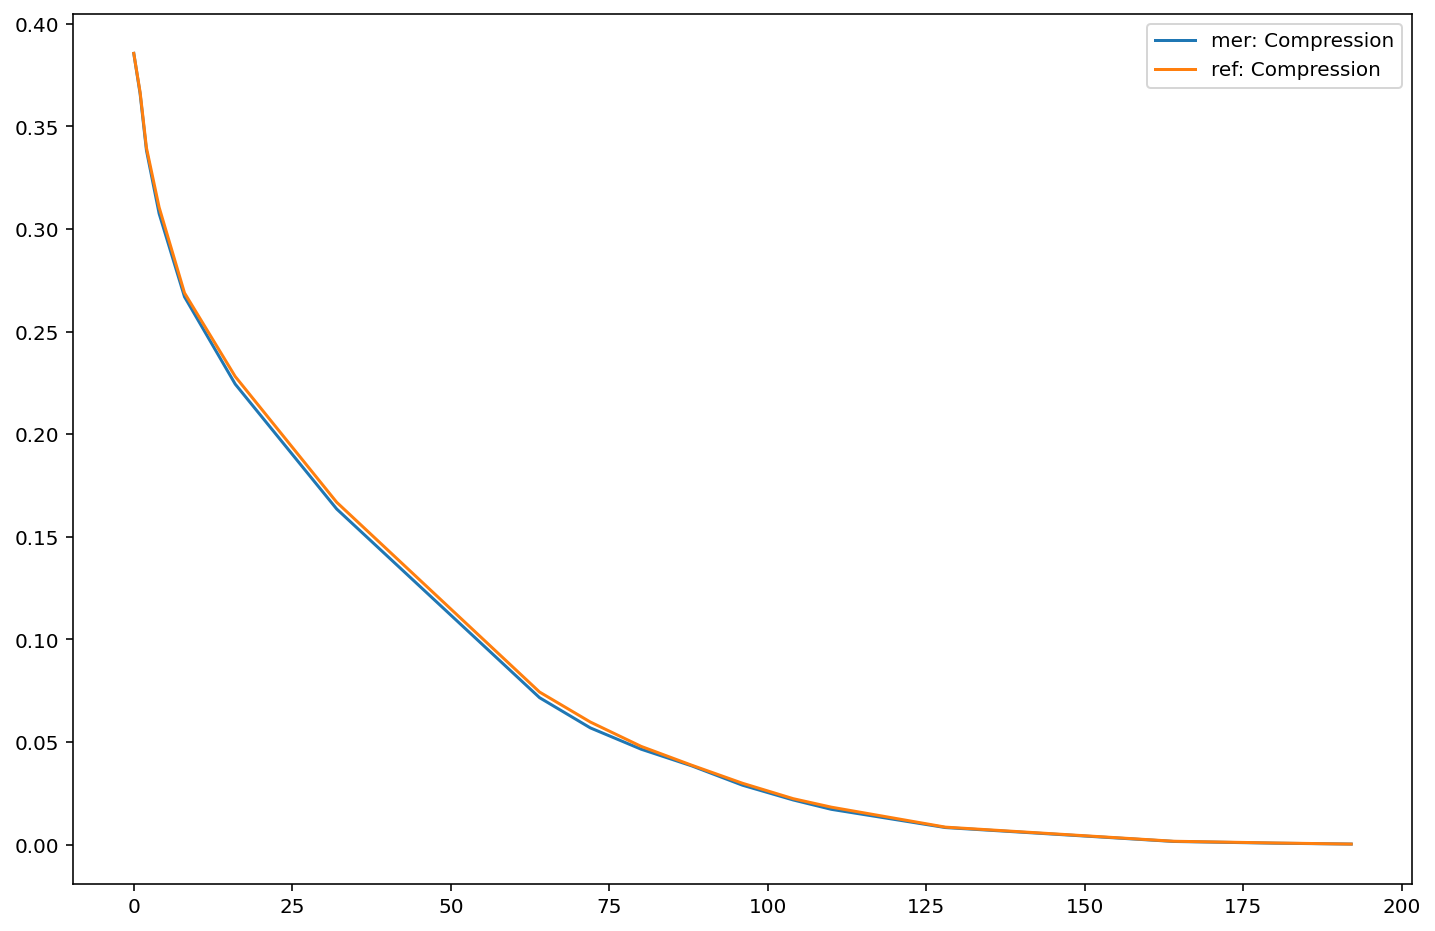

In [9]:
sample_size = 9450
plt.figure(figsize=(12,8))
for prefix in ['mer', 'ref']:
    plt.plot(dfs[prefix+'_anchors']/sample_size, label=prefix+': Compression')

plt.legend();